In [1]:
#Imports
import os
import time
import warnings
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import directed_hausdorff
from scipy.spatial.distance import euclidean

from matplotlib import pyplot as plt

import h5py
import cv2

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import kernels
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.validation import DataConversionWarning as DCW
from sklearn.externals import joblib

!pip install fastdtw
from fastdtw import fastdtw

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Analysis of Similiarities for Forumtracking-Dataset

In [2]:
#All Parameters
source_dataset = "../Datasets/Dataset_forumtracking.hdf5"
final_dataset = "forumtracking.hdf5"

max_trajectory_length = 100
max_nr_trajectories = 100
filter_parameter = ("", 3)

origin = "4"

%run ../code/preprocessing.py
# defines:
# filter_by_origin(path, goal, target=None)
# filter_by_length(path, length, target=None)
# filter_by_number(path, number, target=None)
# filter_trajectory(data, kind=None, windowsize=3)
# adjust_trajectory_length(trajectory, length)
# dp_algorithm(tolerance, trajectory)
# dp_cost_function(tolerance, trajectory)
# process_trajectory(trajectory, length, filter_parameter)

%run ../code/utils.py
# defines:
# create_partial(X, relative_length, fill=None)

# Calculate Distance between Trajectory & Ideals
def calc_distance(X, ideals, method="hausdorff", normed=True):
    distance = np.zeros((X.shape[0], len(ideals)))
    for i, trajectory in enumerate(X):
        if method == "hausdorff":
            for j, data in enumerate(ideals):  
                #print(trajectory.shape)
                #print(data.shape)
                d1 = directed_hausdorff(trajectory, data.T)[0]
                d2 = directed_hausdorff(data.T, trajectory)[0]
                distance[i,j] = max([d1,d2])
        elif method == "dtw":
            for j, data in enumerate(ideals):
                #print(trajectory.shape)
                #print(data.shape)
                d, path = fastdtw(trajectory, data.T, dist=euclidean)
                distance[i,j] = d
        if normed:
            distance[i] = 1./distance[i] / np.sum(1./distance[i]) 
    return distance

/home/clemens/.anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
filter_by_origin(source_dataset, origin, target="forumtracking_short.hdf5")
#filter_by_length("forumtracking_reduced.hdf5", max_trajectory_length, target="forumtracking_short.hdf5")
filter_by_number("forumtracking_short.hdf5", max_nr_trajectories, target=final_dataset)

#os.remove("forumtracking_reduced.hdf5")
os.remove("forumtracking_short.hdf5")
print("Done")

Done


In [2]:
i = 0
with h5py.File(final_dataset, "r") as f:
    count_total = f.attrs["TotalNrTrajectories"]
    X_forum = np.zeros((count_total, max_trajectory_length,2))
    y_forum = np.zeros((count_total,))
    for goal in f:
        for traj in f[goal]:
            trajectory = process_trajectory(f[goal+"/"+traj+"/Positions"][:], \
                                                  max_trajectory_length, \
                                                  filter_parameter)
            X_forum[i] = trajectory
            y_forum[i] = int(goal)
            i += 1
print(X_forum.shape)
print(y_forum.shape)
plt.plot(y_forum)
plt.show()

NameError: name 'h5py' is not defined

In [1]:
def calc_ideals(X, y, goals):
    ideals = []
    for goal in goals:
        X_tmp = X[np.where(y == int(goal))]
        print(X_tmp.shape)
        mx = np.mean(X_tmp[:,:,0], axis=0)
        my = np.mean(X_tmp[:,:,1], axis=0)
        ideals.append(np.array([mx, my]))
    return ideals

goals = [el for el in range(1,9)]
ideals_forum = calc_ideals(X_forum, y_forum, goals)
np.save("Results/exp_6_0_forum_ideals.npy", ideals_forum)
img_forum = cv2.imread("../Datasets/Images/forumtracking.png")
for ideal in ideals_forum:
    plt.plot(ideal[0,:], ideal[1,:])
plt.imshow(img_forum)
plt.show()

NameError: name 'X_forum' is not defined

In [6]:
def new_create_partial(X, relative_length):
    partial = np.zeros_like(X)
    length = int(relative_length * X.shape[1])
    t = np.arange(X.shape[1])
    ti = np.linspace(0, int(relative_length*X.shape[1])-1, X.shape[1])

    for i in range(X.shape[0]):        
        fx = interp1d(t, X[i,:,0])
        fy = interp1d(t, X[i,:,1])
        partial[i,:,0] = fx(ti)
        partial[i,:,1] = fy(ti)
    return partial

# Only similiarity-classification

In [ ]:
rel_lengths = np.linspace(0.1,1.0,20)
correct_forum_haus = []
correct_forum_dtw = []
    
for rel in rel_lengths:
    correct_forum_haus_rel = 0
    correct_forum_dtw_rel = 0

    partial_haus = calc_distance(new_create_partial(X_forum, rel), ideals_forum, method="hausdorff", normed=True)
    print("Haus-Calculated")
    partial_dtw = calc_distance(new_create_partial(X_forum, rel), ideals_forum, method="dtw", normed=True)
    print("DTW-Calculated")
    for i, row in enumerate(partial_haus):
        if np.argmax(row) == y_forum[i]-1 :
            correct_forum_haus_rel += 1
    for i, row in enumerate(partial_dtw):
        if np.argmax(row) ==  y_forum[i]-1 :
            correct_forum_dtw_rel += 1
    correct_forum_haus_percent = 100*correct_forum_haus_rel/X_forum.shape[0]
    correct_forum_dtw_percent = 100*correct_forum_dtw_rel/X_forum.shape[0]
    correct_forum_haus.append(correct_forum_haus_percent)
    correct_forum_dtw.append(correct_forum_dtw_percent)

    print(round(rel,2),": ",correct_forum_haus_percent, ",",correct_forum_dtw_percent)
    #print(round(rel,2),": ",correct_forum_haus_percent)
np.save("Results/exp_6_1_rel_lengths.npy", rel_lengths)
np.save("Results/exp_6_1_correct_forum_haus.npy", correct_forum_haus)
np.save("Results/exp_6_1_correct_forum_dtw.npy",  correct_forum_dtw)

# Evaluation

In [17]:
K_haus_sum = kernels.Sum(kernels.RBF(0.087992254356910701), \
                         kernels.WhiteKernel(1e-06))   
K_dtw_sum = kernels.Sum(kernels.RBF(0.0024484367468222269), \
                         kernels.WhiteKernel(1e-06))   
GP_haus_sum = GaussianProcessClassifier(K_haus_sum, multi_class="one_vs_rest")
GP_dtw_sum = GaussianProcessClassifier(K_dtw_sum, multi_class="one_vs_rest")

K_haus_rbf = kernels.RBF(0.001291549665014884)
K_dtw_rbf = kernels.RBF(0.0046415888336127772)
GP_haus_rbf = GaussianProcessClassifier(K_haus_rbf, multi_class="one_vs_rest")
GP_dtw_rbf = GaussianProcessClassifier(K_dtw_rbf, multi_class="one_vs_rest")

K_haus_mat15 = kernels.Matern(nu=1.5, length_scale=0.0014384498882876629)
K_dtw_mat15 = kernels.Matern(nu=1.5, length_scale=0.00029763514416313134)
GP_haus_mat15 = GaussianProcessClassifier(K_haus_mat15, multi_class="one_vs_rest")
GP_dtw_mat15 = GaussianProcessClassifier(K_dtw_mat15, multi_class="one_vs_rest")

K_haus_mat05 = kernels.Matern(nu=0.5, length_scale=0.00014384498882876631)
K_dtw_mat05 = kernels.Matern(nu=0.5, length_scale=0.00014384498882876631)
GP_haus_mat05 = GaussianProcessClassifier(K_haus_mat05, multi_class="one_vs_rest")
GP_dtw_mat05 = GaussianProcessClassifier(K_dtw_mat05, multi_class="one_vs_rest")

K_haus_lin = kernels.DotProduct(sigma_0=0.01)
K_dtw_lin = kernels.DotProduct(sigma_0=0.0016681005372000592)
GP_haus_lin = GaussianProcessClassifier(K_haus_lin, multi_class="one_vs_rest")
GP_dtw_lin = GaussianProcessClassifier(K_dtw_lin, multi_class="one_vs_rest")

In [ ]:
rel_lengths = np.linspace(0.1,0.99,20)

score_haus_sum, score_dtw_sum = [], []
score_haus_rbf, score_dtw_rbf = [], []
score_haus_mat15, score_dtw_mat15 = [], []
score_haus_lin, score_dtw_lin = [], []

for rel in rel_lengths:
    start0 = time.time()
    start = time.time()
    partial_haus = calc_distance(new_create_partial(X_forum, rel), ideals_forum, method="hausdorff", normed=True)
    partial_dtw = calc_distance(new_create_partial(X_forum, rel), ideals_forum, method="dtw", normed=True)
    print("Distances for %.2f percent calculated in %fs..."%(rel, time.time()-start))
    
    start = time.time()
    score_haus_sum.append(100*cross_val_score(GP_haus_sum, partial_haus, y_forum, cv=3).mean())
    score_dtw_sum.append(100*cross_val_score(GP_dtw_sum, partial_haus, y_forum, cv=3).mean())
    print("Finished SUM in %f"%(time.time()-start))
    start = time.time()
    score_haus_rbf.append(100*cross_val_score(GP_haus_rbf, partial_haus, y_forum, cv=3).mean())
    score_dtw_rbf.append(100*cross_val_score(GP_dtw_rbf, partial_haus, y_forum, cv=3).mean())
    print("Finished RBF in %f"%(time.time()-start))
    start = time.time()
    #score_haus_mat15.append(100*cross_val_score(GP_haus_mat15, partial_haus, y_forum, cv=3).mean())
    #score_dtw_mat15.append(100*cross_val_score(GP_dtw_mat15, partial_haus, y_forum, cv=3).mean())
    print("Finished MAT in %f"%(time.time()-start))
    start = time.time()
    #score_haus_lin.append(100*cross_val_score(GP_haus_lin, partial_haus, y_forum, cv=3).mean())
    #score_dtw_lin.append(100*cross_val_score(GP_dtw_lin, partial_haus, y_forum, cv=3).mean())
    print("Finished LIN in %f"%(time.time()-start))
    print("Fitting done in %fs..."%(time.time()-start0))

Distances for 0.10 percent calculated in 182.596802s...
Finished SUM in 487.890381
Finished RBF in 853.185609
Finished MAT in 0.000001
Finished LIN in 0.000001
Fitting done in 1523.677967s...
Distances for 0.15 percent calculated in 196.351502s...
Finished SUM in 440.317243
Finished RBF in 612.170887
Finished MAT in 0.000001
Finished LIN in 0.000000
Fitting done in 1248.843110s...
Distances for 0.19 percent calculated in 200.901876s...


/home/clemens/.anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpc.py:430: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.06634314e-05,   6.55415527e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/clemens/.anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpc.py:430: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.74745592e-05,   6.55700272e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)


Finished SUM in 1080.834476
Finished RBF in 325.213141
Finished MAT in 0.000001
Finished LIN in 0.000001
Fitting done in 1606.951155s...
Distances for 0.24 percent calculated in 169.503234s...
Finished SUM in 1136.541908
Finished RBF in 315.209565
Finished MAT in 0.000001
Finished LIN in 0.000000
Fitting done in 1621.255466s...
Distances for 0.29 percent calculated in 206.806952s...
Finished SUM in 934.527748
Finished RBF in 308.267907
Finished MAT in 0.000001
Finished LIN in 0.000000
Fitting done in 1449.603644s...
Distances for 0.33 percent calculated in 196.730096s...
Finished SUM in 786.819061
Finished RBF in 313.700294
Finished MAT in 0.000002
Finished LIN in 0.000000
Fitting done in 1297.252667s...
Distances for 0.38 percent calculated in 202.788638s...
Finished SUM in 979.924531
Finished RBF in 418.206049
Finished MAT in 0.000001
Finished LIN in 0.000000
Fitting done in 1600.923069s...
Distances for 0.43 percent calculated in 203.483766s...
Finished SUM in 1023.775528
Finished R

In [16]:
np.save("Results/exp_6_1_score_haus_sum", score_haus_sum)
np.save("Results/exp_6_1_score_dtw_sum", score_dtw_sum)
np.save("Results/exp_6_1_score_haus_rbf", score_haus_rbf)
np.save("Results/exp_6_2_score_dtw_rbf", score_dtw_rbf)
#np.save("Results/exp_6_1_score_haus_mat15", score_haus_mat15)
#np.save("Results/exp_6_1_score_dtw_mat15", score_dtw_mat15)
#np.save("Results/exp_6_1_score_haus_lin", score_haus_lin)
#np.save("Results/exp_6_1_score_dtw_lin", score_dtw_lin)

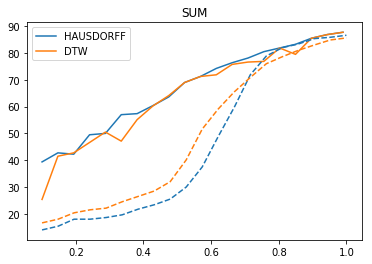

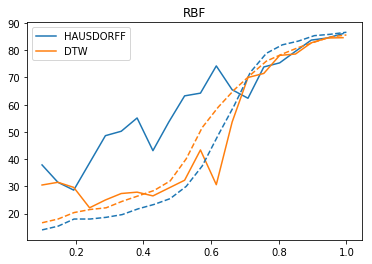

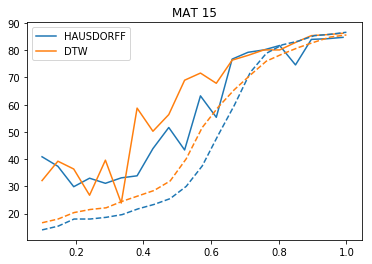

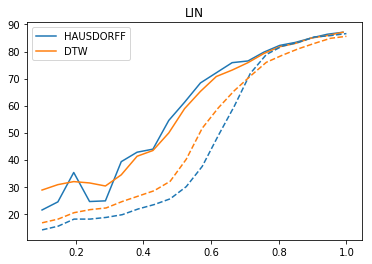

In [26]:
correct_haus = np.load("Results/exp_5_3_correct_forum_haus.npy")
correct_dtw = np.load("Results/exp_5_3_correct_forum_dtw.npy")
correct_lenghths = np.load("Results/exp_5_3_rel_lengths.npy")

plt.title("SUM")
plt.plot(rel_lengths,  score_haus_sum,label="HAUSDORFF",c="C0")
plt.plot(rel_lengths, score_dtw_sum,label="DTW",c="C1")
plt.plot(correct_lenghths, correct_haus,linestyle="--",c="C0")
plt.plot(correct_lenghths, correct_dtw,linestyle="--",c="C1")
plt.legend()
plt.show()

plt.title("RBF")
plt.plot(rel_lengths,  score_haus_rbf,label="HAUSDORFF",c="C0")
plt.plot(rel_lengths, score_dtw_rbf,label="DTW",c="C1")
plt.plot(correct_lenghths, correct_haus,linestyle="--",c="C0")
plt.plot(correct_lenghths, correct_dtw,linestyle="--",c="C1")
plt.legend()
plt.show()

plt.title("MAT 15")
plt.plot(rel_lengths,  score_haus_mat15,label="HAUSDORFF",c="C0")
plt.plot(rel_lengths, score_dtw_mat15,label="DTW",c="C1")
plt.plot(correct_lenghths, correct_haus,linestyle="--",c="C0")
plt.plot(correct_lenghths, correct_dtw,linestyle="--",c="C1")
plt.legend()
plt.show()

plt.title("LIN")
plt.plot(rel_lengths,  score_haus_lin,label="HAUSDORFF",c="C0")
plt.plot(rel_lengths, score_dtw_lin,label="DTW",c="C1")
plt.plot(correct_lenghths, correct_haus,linestyle="--",c="C0")
plt.plot(correct_lenghths, correct_dtw,linestyle="--",c="C1")
plt.legend()
plt.show()